In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128

np.random.seed(42)
torch.manual_seed(42)

train_dataset = datasets.MNIST('mnist_data/', train=True, download=True,
                               transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True,
                              transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307) / 0.3081


class IntervalBounds:
    def __init__(self, lower, upper):
        self.lower = lower
        self.upper = upper


def interval_linear(W, b, x_interval):
    W_pos = torch.clamp(W, min=0)
    W_neg = torch.clamp(W, max=0)
    lower = x_interval.lower @ W_pos.T + x_interval.upper @ W_neg.T + b
    upper = x_interval.upper @ W_pos.T + x_interval.lower @ W_neg.T + b
    return IntervalBounds(lower, upper)


def interval_relu(x_interval):
    lower = torch.clamp(x_interval.lower, min=0)
    upper = torch.clamp(x_interval.upper, min=0)
    return IntervalBounds(lower, upper)


def interval_normalize(x_interval, mean=0.1307, std=0.3081):
    lower = (x_interval.lower - mean) / std
    upper = (x_interval.upper - mean) / std
    return IntervalBounds(lower, upper)


def propagate_intervals(net, x_lower, x_upper, use_gradient=True):
    x_interval = IntervalBounds(x_lower, x_upper)
    x_interval = interval_normalize(x_interval)
    
    x_interval.lower = x_interval.lower.view(-1, 28*28)
    x_interval.upper = x_interval.upper.view(-1, 28*28)
    
    if use_gradient:
        W1, b1 = net.fc1.weight, net.fc1.bias
    else:
        W1, b1 = net.fc1.weight.data, net.fc1.bias.data
    x_interval = interval_linear(W1, b1, x_interval)
    x_interval = interval_relu(x_interval)
    
    if use_gradient:
        W2, b2 = net.fc2.weight, net.fc2.bias
    else:
        W2, b2 = net.fc2.weight.data, net.fc2.bias.data
    x_interval = interval_linear(W2, b2, x_interval)
    x_interval = interval_relu(x_interval)
    
    if use_gradient:
        W3, b3 = net.fc3.weight, net.fc3.bias
    else:
        W3, b3 = net.fc3.weight.data, net.fc3.bias.data
    x_interval = interval_linear(W3, b3, x_interval)
    x_interval = interval_relu(x_interval)
    
    if use_gradient:
        W4, b4 = net.fc4.weight, net.fc4.bias
    else:
        W4, b4 = net.fc4.weight.data, net.fc4.bias.data
    x_interval = interval_linear(W4, b4, x_interval)
    
    return x_interval.lower, x_interval.upper


def get_adversarial_logits(model, images, labels, epsilon):
    x_lower = torch.clamp(images - epsilon, min=0.0, max=1.0)
    x_upper = torch.clamp(images + epsilon, min=0.0, max=1.0)
    
    net = model[1] if isinstance(model, nn.Sequential) else model
    output_lower, output_upper = propagate_intervals(net, x_lower, x_upper, use_gradient=True)
    
    batch_size = labels.size(0)
    classes = torch.arange(10, device=labels.device).unsqueeze(0).expand(batch_size, -1)
    mask = (classes == labels.unsqueeze(-1)).float()
    
    adversarial_logit = (1 - mask) * output_upper + mask * output_lower
    
    return adversarial_logit


def train_standard(model, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
    
    training_time = time.time() - start_time
    print(f'Standard training time: {training_time:.2f}s')
    return training_time


def train_ibp(model, num_epochs, target_epsilon=0.1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    start_time = time.time()
    
    kappa_schedule = np.linspace(1.0, 0.5, num_epochs)
    epsilon_schedule = np.linspace(0.0, target_epsilon, num_epochs)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_ce = 0.0
        running_robust = 0.0
        kappa = kappa_schedule[epoch]
        epsilon_train = epsilon_schedule[epoch]
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            ce_loss = criterion(outputs, labels)
            
            if epsilon_train > 0:
                adv_logits = get_adversarial_logits(model, images, labels, epsilon_train)
                robust_loss = criterion(adv_logits, labels)
                loss = kappa * ce_loss + (1 - kappa) * robust_loss
                running_robust += robust_loss.item()
            else:
                loss = ce_loss
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_ce += ce_loss.item()
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
                  f'CE: {running_ce/len(train_loader):.4f}, '
                  f'Robust: {running_robust/len(train_loader):.4f}, '
                  f'κ: {kappa:.2f}, ε: {epsilon_train:.4f}')
    
    training_time = time.time() - start_time
    print(f'IBP training time: {training_time:.2f}s')
    return training_time


def test_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Standard Accuracy: {accuracy:.2f}%')
    return accuracy


def pgd_attack(model, images, labels, epsilon, alpha=0.01, num_steps=40):
    images = images.clone().detach()
    adv_images = images.clone().detach()
    adv_images = adv_images + torch.empty_like(adv_images).uniform_(-epsilon, epsilon)
    adv_images = torch.clamp(adv_images, 0, 1).detach()
    
    for _ in range(num_steps):
        adv_images.requires_grad = True
        outputs = model(adv_images)
        loss = F.cross_entropy(outputs, labels)
        
        grad = torch.autograd.grad(loss, adv_images)[0]
        
        adv_images = adv_images.detach() + alpha * grad.sign()
        delta = torch.clamp(adv_images - images, min=-epsilon, max=epsilon)
        adv_images = torch.clamp(images + delta, min=0, max=1).detach()
    
    return adv_images


def test_robust(model, epsilon=0.1):
    model.eval()
    correct = 0
    total = 0
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        adv_images = pgd_attack(model, images, labels, epsilon)
        
        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Robust Accuracy (ε={epsilon:.2f}): {accuracy:.2f}%')
    return accuracy


def verify_robustness(net, image, label, epsilon):
    x_lower = torch.clamp(image - epsilon, min=0.0, max=1.0)
    x_upper = torch.clamp(image + epsilon, min=0.0, max=1.0)
    
    output_lower, output_upper = propagate_intervals(net, x_lower, x_upper, use_gradient=False)
    
    correct_class_lower = output_lower[0, label]
    
    other_classes_upper = torch.cat([
        output_upper[0, :label],
        output_upper[0, label+1:]
    ])
    
    max_other_upper = torch.max(other_classes_upper)
    
    verified = correct_class_lower > max_other_upper
    
    return verified.item()


def compute_verified_accuracy(model, epsilon_values):
    model.eval()
    net = model[1] if isinstance(model, nn.Sequential) else model
    verified_accuracies = []
    
    print(f'\nComputing verified accuracies...')
    
    for eps in epsilon_values:
        verified_count = 0
        total_count = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                
                for i in range(len(images)):
                    if predicted[i] == labels[i]:
                        if verify_robustness(net, images[i:i+1], labels[i], eps):
                            verified_count += 1
                    total_count += 1
        
        verified_accuracy = 100 * verified_count / total_count
        verified_accuracies.append(verified_accuracy)
        print(f'ε = {eps:.3f}: Verified Accuracy = {verified_accuracy:.2f}%')
    
    return verified_accuracies

In [4]:
# Standard training
model_standard = nn.Sequential(Normalize(), Net()).to(device)
time_standard = train_standard(model_standard, num_epochs=15)
acc_standard = test_model(model_standard)
robust_standard = test_robust(model_standard, epsilon=0.1)

Epoch [5/15], Loss: 0.0877
Epoch [10/15], Loss: 0.0487
Epoch [15/15], Loss: 0.0310
Standard training time: 60.35s
Standard Accuracy: 97.13%
Robust Accuracy (ε=0.10): 8.42%


In [5]:
# IBP training
model_ibp = nn.Sequential(Normalize(), Net()).to(device)
time_ibp = train_ibp(model_ibp, num_epochs=15, target_epsilon=0.1)
acc_ibp = test_model(model_ibp)
robust_ibp = test_robust(model_ibp, epsilon=0.1)

Epoch [5/15], Loss: 0.2548, CE: 0.1449, Robust: 0.9141, κ: 0.86, ε: 0.0286
Epoch [10/15], Loss: 0.3550, CE: 0.1496, Robust: 0.7887, κ: 0.68, ε: 0.0643
Epoch [15/15], Loss: 0.5946, CE: 0.1970, Robust: 0.9922, κ: 0.50, ε: 0.1000
IBP training time: 75.36s
Standard Accuracy: 94.53%
Robust Accuracy (ε=0.10): 84.11%


In [6]:
# Training time comparison
print(f'Standard training: {time_standard:.2f}s')
print(f'IBP training: {time_ibp:.2f}s')
print(f'Time overhead: {(time_ibp/time_standard - 1)*100:.1f}%')

Standard training: 60.35s
IBP training: 75.36s
Time overhead: 24.9%


In [7]:
# Verified accuracy
epsilon_values = np.linspace(0.01, 0.1, 10)
verified_accs = compute_verified_accuracy(model_ibp, epsilon_values)


Computing verified accuracies...
ε = 0.010: Verified Accuracy = 93.71%
ε = 0.020: Verified Accuracy = 92.70%
ε = 0.030: Verified Accuracy = 91.55%
ε = 0.040: Verified Accuracy = 90.23%
ε = 0.050: Verified Accuracy = 88.84%
ε = 0.060: Verified Accuracy = 87.01%
ε = 0.070: Verified Accuracy = 85.10%
ε = 0.080: Verified Accuracy = 82.68%
ε = 0.090: Verified Accuracy = 80.07%
ε = 0.100: Verified Accuracy = 76.59%


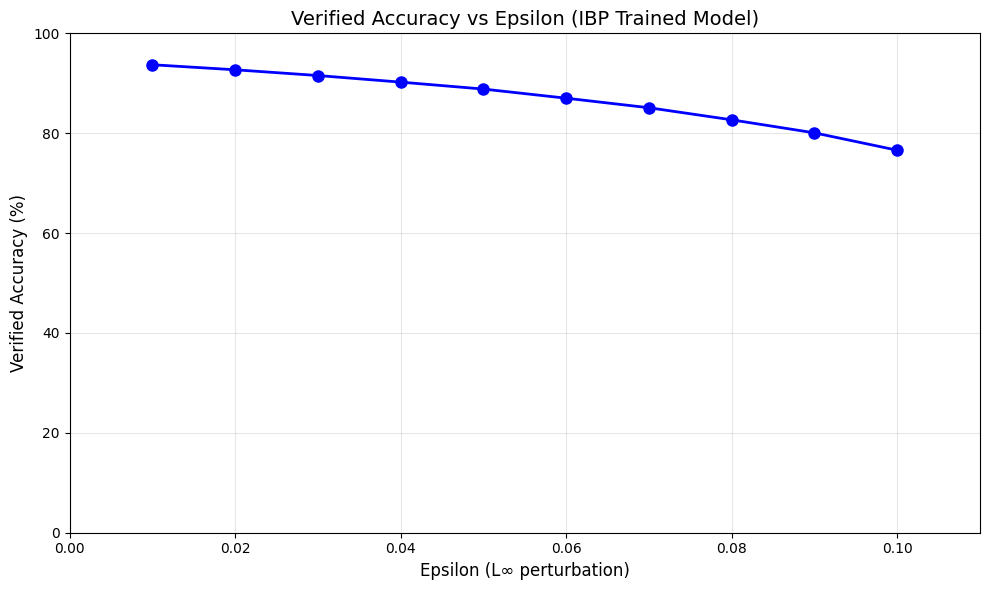

In [8]:
# Generate plots
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, verified_accs, 'b-o', linewidth=2, markersize=8)
plt.xlabel('Epsilon (L∞ perturbation)', fontsize=12)
plt.ylabel('Verified Accuracy (%)', fontsize=12)
plt.title('Verified Accuracy vs Epsilon (IBP Trained Model)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xlim(0, 0.11)
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('verified_accuracy.png', dpi=150)
plt.show()

In [9]:
# Summary
print(f'Standard Model - Clean Acc: {acc_standard:.2f}%, Robust Acc: {robust_standard:.2f}%')
print(f'IBP Model - Clean Acc: {acc_ibp:.2f}%, Robust Acc: {robust_ibp:.2f}%')
print(f'Verified Accuracy at ε=0.01: {verified_accs[0]:.2f}%')
print(f'Verified Accuracy at ε=0.1: {verified_accs[-1]:.2f}%')

Standard Model - Clean Acc: 97.13%, Robust Acc: 8.42%
IBP Model - Clean Acc: 94.53%, Robust Acc: 84.11%
Verified Accuracy at ε=0.01: 93.71%
Verified Accuracy at ε=0.1: 76.59%


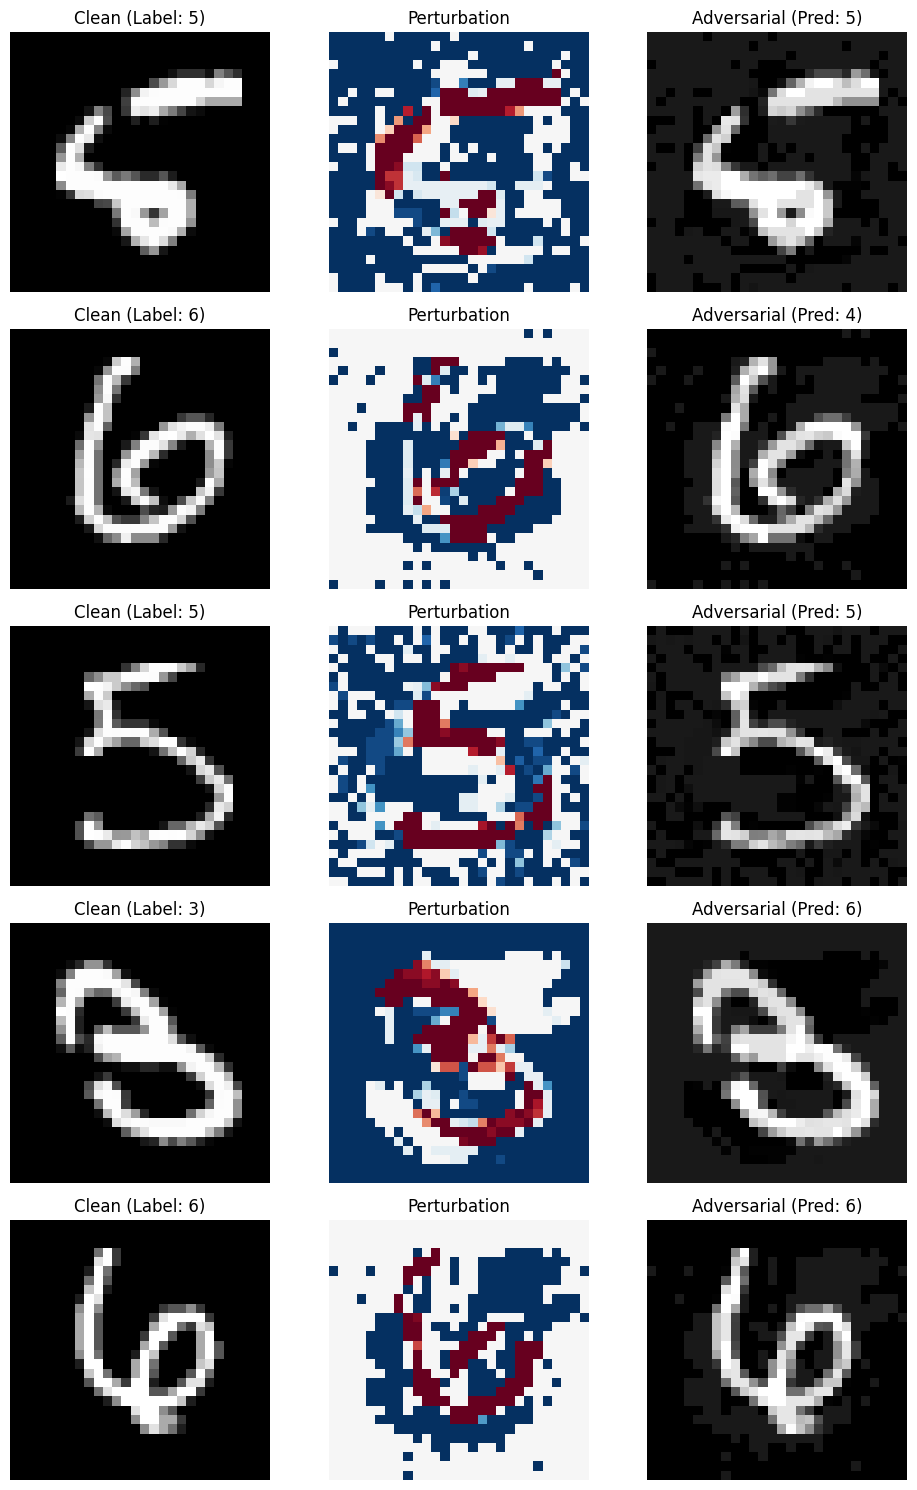

In [10]:
# Find and visualize failed verification cases
def analyze_failed_verifications(model, epsilon_test=0.1, num_examples=5):
    model.eval()
    net = model[1] if isinstance(model, nn.Sequential) else model
    failed_examples = []
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        for i in range(len(images)):
            if predicted[i] == labels[i]:  # Correctly classified
                if not verify_robustness(net, images[i:i+1], labels[i], epsilon_test):
                    # Failed verification - generate adversarial example
                    adv_img = pgd_attack(model, images[i:i+1], labels[i:i+1], epsilon_test)
                    failed_examples.append({
                        'clean': images[i],
                        'adv': adv_img[0],
                        'label': labels[i].item(),
                        'pred_clean': predicted[i].item()
                    })
                    
                    if len(failed_examples) >= num_examples:
                        break
        if len(failed_examples) >= num_examples:
            break
    
    # Visualize
    fig, axes = plt.subplots(num_examples, 3, figsize=(10, 3*num_examples))
    for idx, example in enumerate(failed_examples):
        # Clean image
        axes[idx, 0].imshow(example['clean'].cpu().squeeze(), cmap='gray')
        axes[idx, 0].set_title(f'Clean (Label: {example["label"]})')
        axes[idx, 0].axis('off')
        
        # Perturbation
        perturbation = (example['adv'] - example['clean']).cpu()
        axes[idx, 1].imshow(perturbation.squeeze(), cmap='RdBu', vmin=-epsilon_test, vmax=epsilon_test)
        axes[idx, 1].set_title('Perturbation')
        axes[idx, 1].axis('off')
        
        # Adversarial image
        axes[idx, 2].imshow(example['adv'].cpu().squeeze(), cmap='gray')
        adv_pred = torch.argmax(model(example['adv'].unsqueeze(0).to(device)))
        axes[idx, 2].set_title(f'Adversarial (Pred: {adv_pred.item()})')
        axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('adversarial_examples.png', dpi=150, bbox_inches='tight')
    plt.show()

# Run the analysis
analyze_failed_verifications(model_ibp, epsilon_test=0.1, num_examples=5)